In [3]:
sys.path.insert(1, '/home/sidtandon/Sid/GitRepo/fastshap')

In [4]:
from unet import UNet
from fastshap import FastSHAP

from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os.path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from copy import deepcopy
from resnet import ResNet18

import torchvision.datasets as dsets
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings('ignore')

/home/sidtandon/Sid/GitRepo/fastshap/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
device = torch.device('cuda')

In [7]:
orig_model = ResNet18(num_classes=10)
orig_model.load_state_dict(torch.load('cifar resnet.pt'))
orig_model.to(device)
orig_model.eval()

surr_model = nn.Sequential(
        MaskLayer2d(value=0, append=True),
        ResNet18(in_channels=4, num_classes=10))
surr_model.load_state_dict(torch.load('cifar surrogate.pt'))
surr_model.to(device)
surr_model.eval()

surrogate = ImageSurrogate(surr_model, width=32, height=32, superpixel_size=2)

dset = val_set
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
if type(inds[0]) is np.ndarray:
    inds = np.concatenate(inds).ravel() 
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)


pred = surrogate(
    x.to(device),
    torch.ones(num_classes, surrogate.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

#orig = orig_model(x.to(device))


In [8]:
orig_preds = orig_model(x.to(device)).softmax(dim=1).cpu().data.numpy()

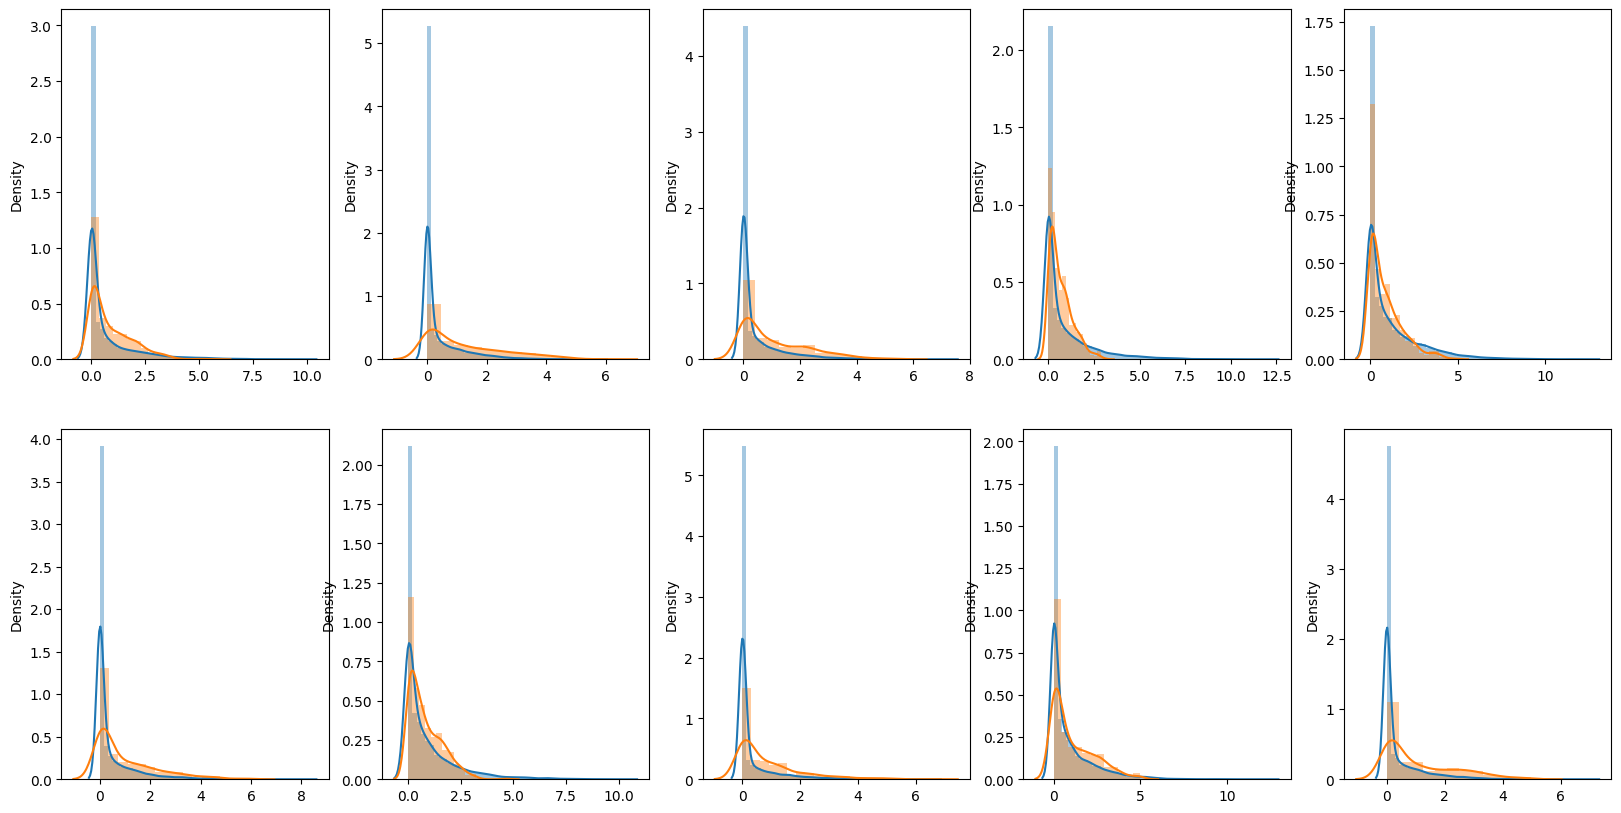

In [9]:
# Plot last conv layer output
import matplotlib.pyplot as plt
import seaborn as sns

instance_index = 4
surr_np = np.load("./lastconv_surr.npy")
orig_np = np.load("./lastconv_orig.npy")

rows = 2
cols = 10 // rows
fig, axarr = plt.subplots(rows, cols, figsize=(20, 10))
index = 0
for row in range(rows):
    for col in range(cols):
        sns.distplot(surr_np[index].squeeze(), kde = True, ax = axarr[row,col])
        sns.distplot(orig_np[index].squeeze(), kde = True, ax = axarr[row,col])
        #axarr[row,col].hist(surr_np[index].squeeze())
        #axarr[row,col].hist(orig_np[index].squeeze())
        index+=1
        if index>=num_classes:
            break
#plt.hist(values[0,1,:,:].flatten(), kde=True)



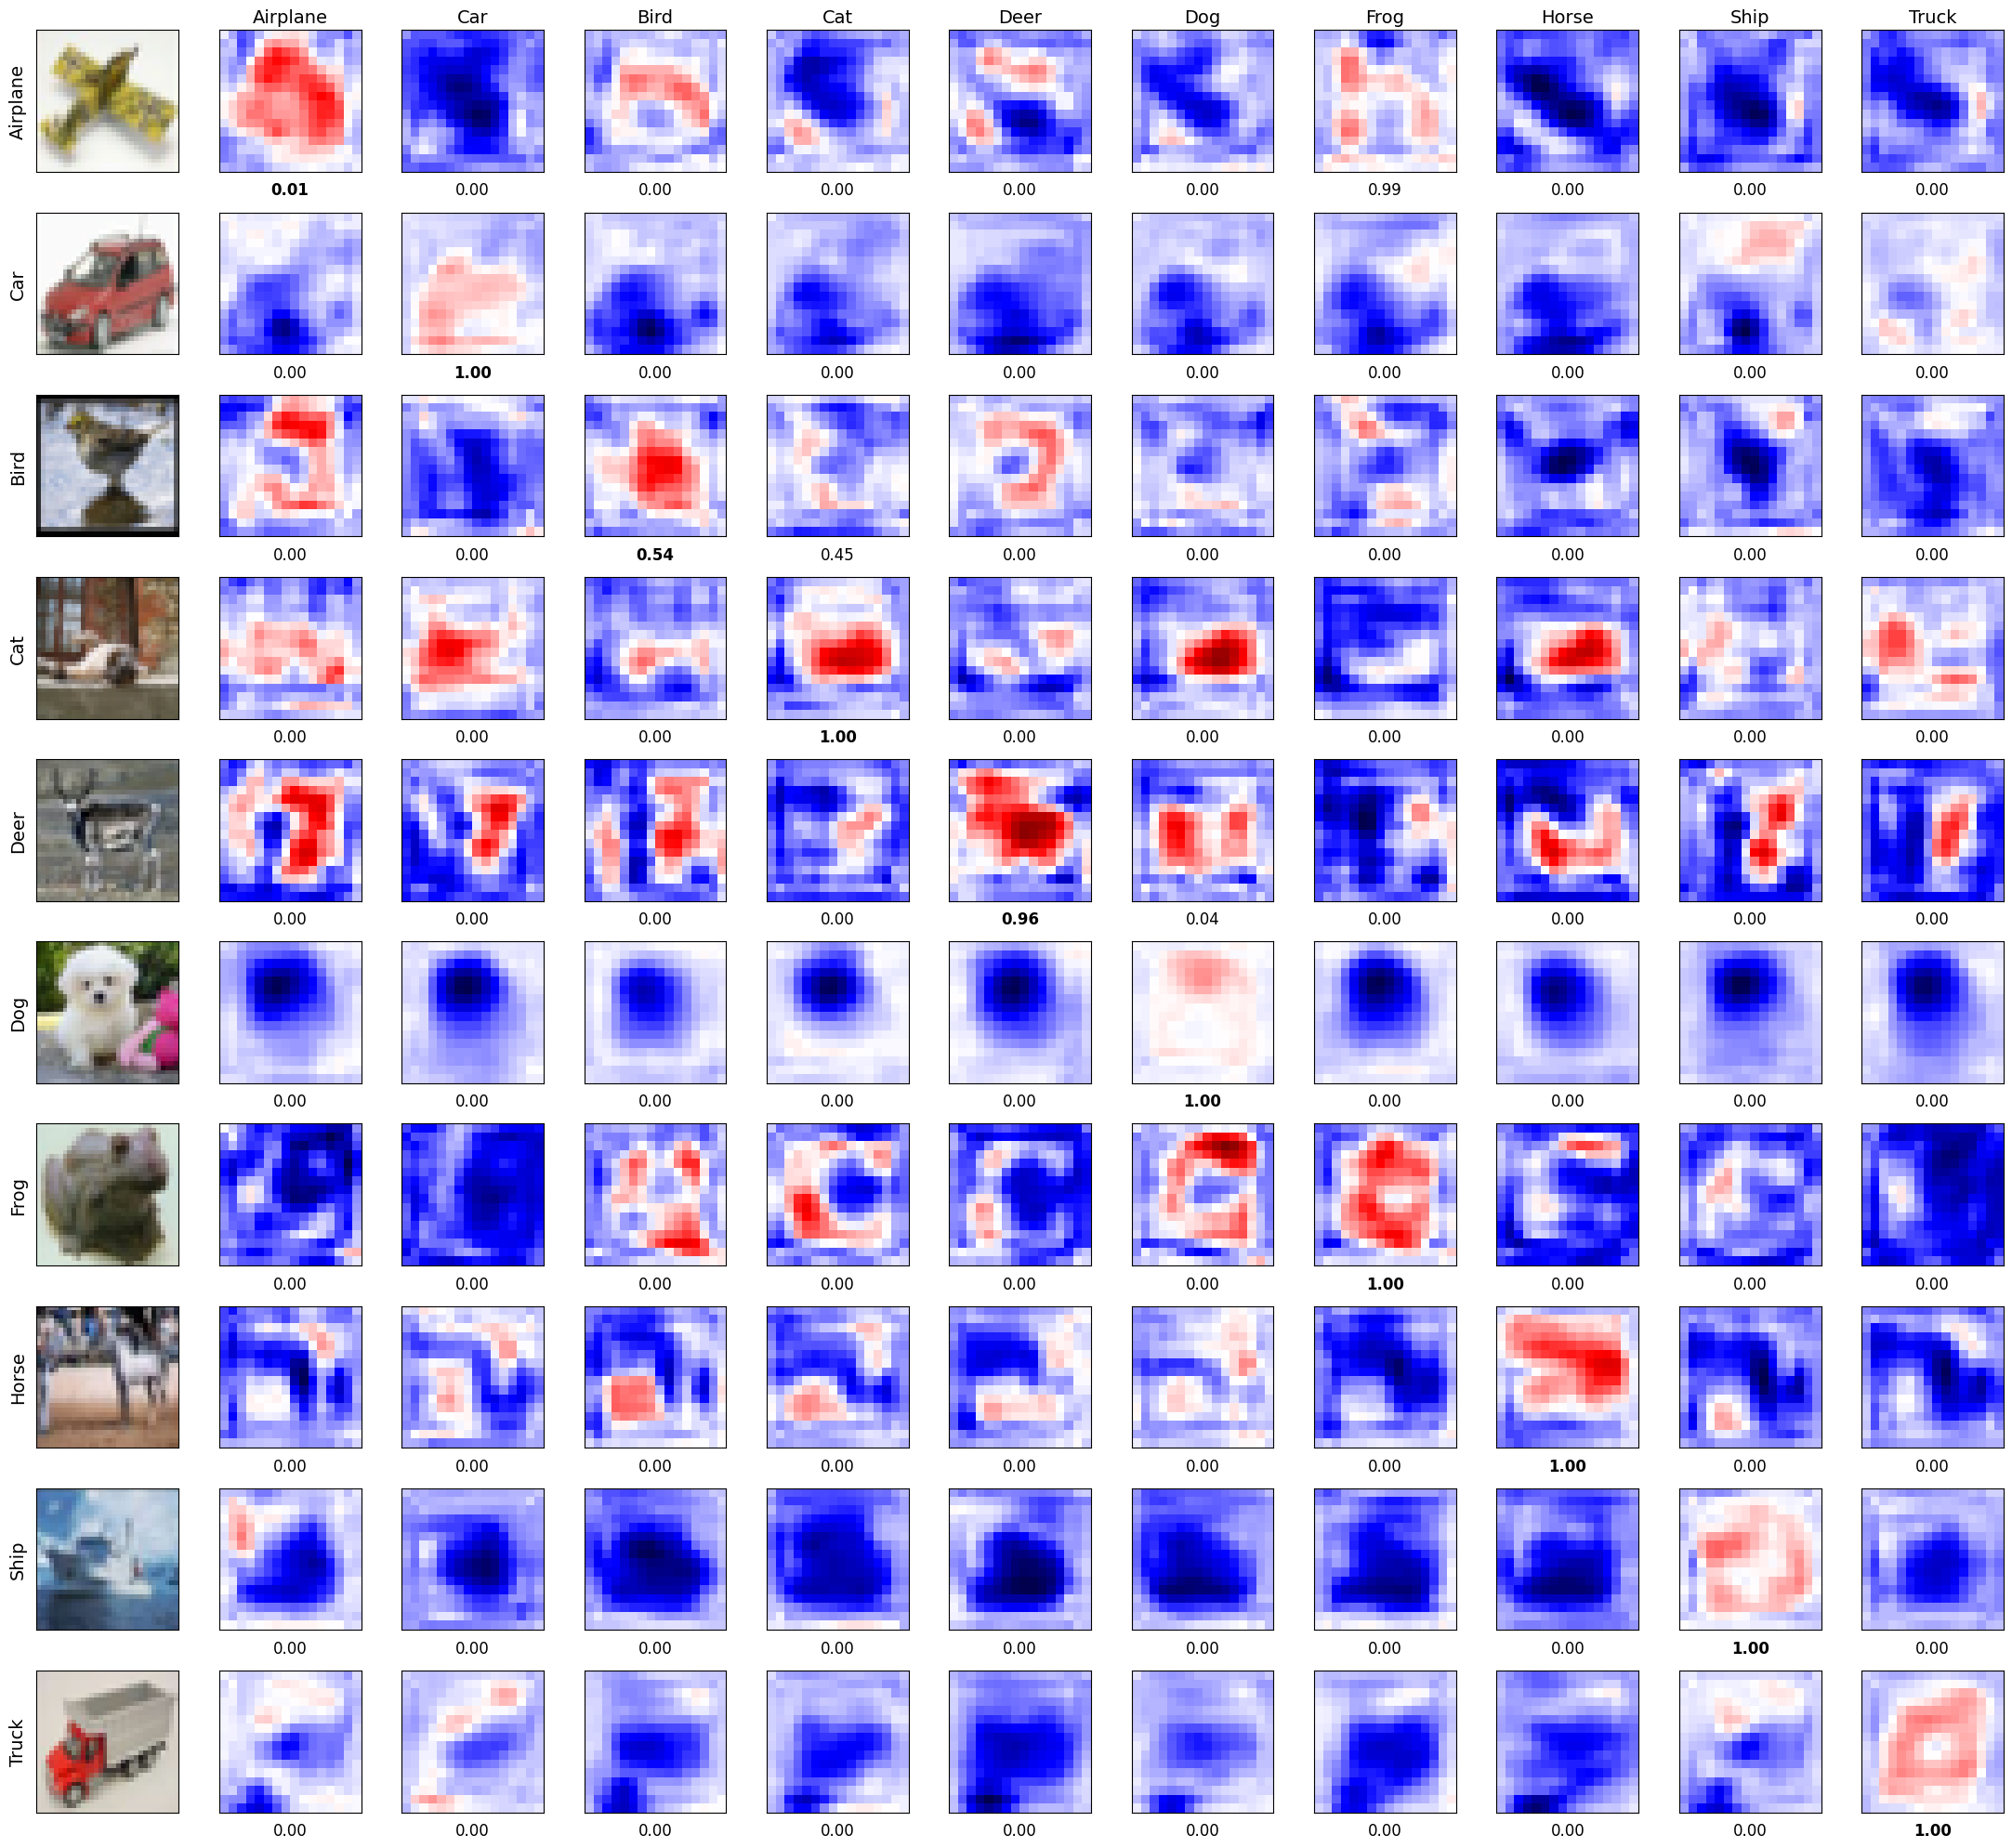

In [10]:
explainer = torch.load('cifar explainer.pt').to(device)
fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

# Get explanations
values = fastshap.shap_values(x.to(device))

# Get predictions
pred = surrogate(
    x.to(device),
    torch.ones(num_classes, surrogate.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
        else:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.show()

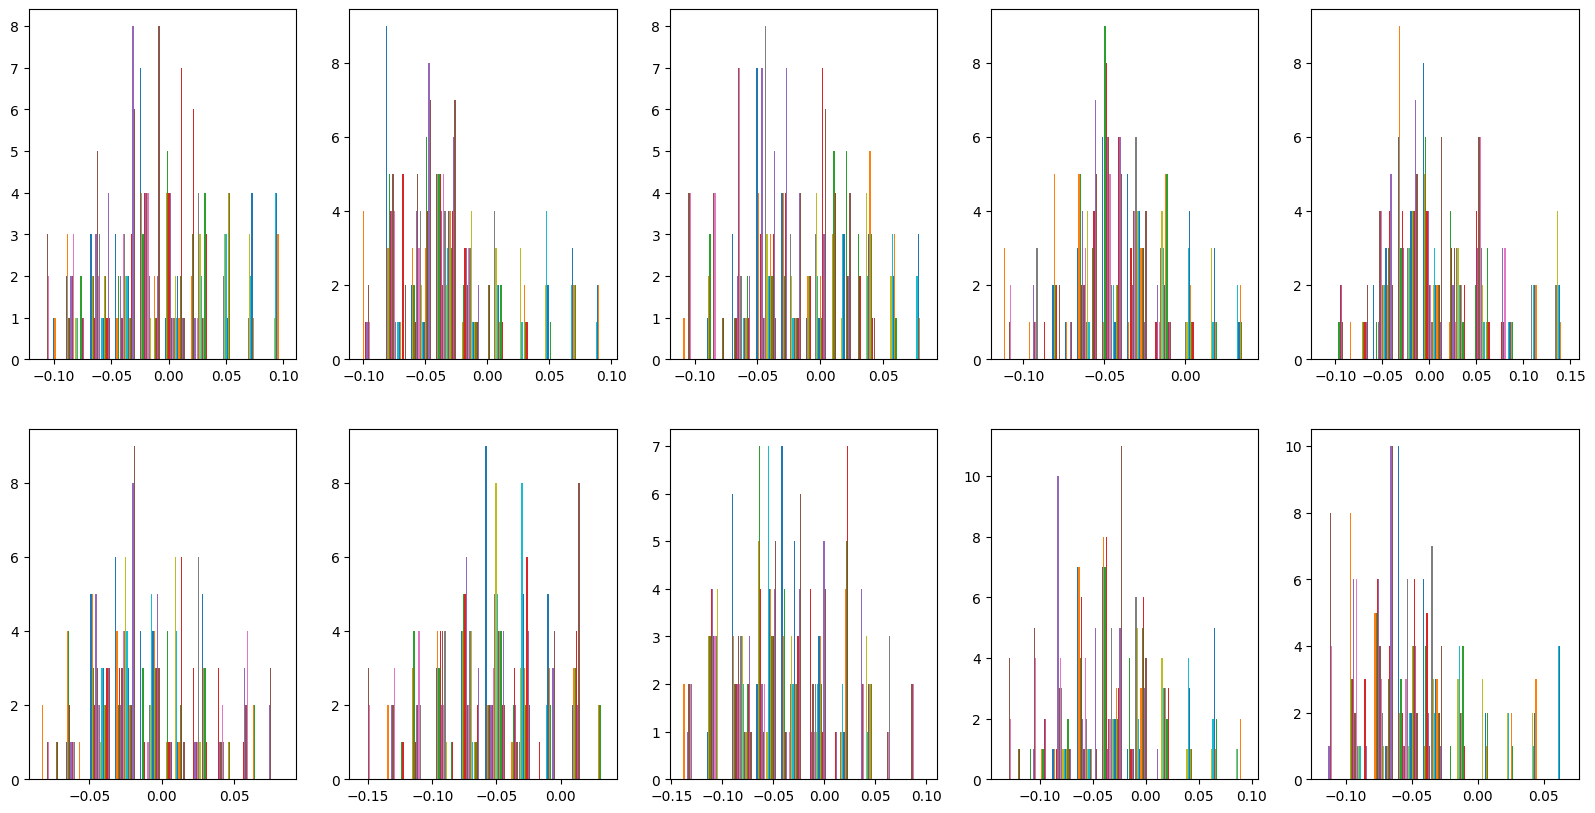

In [11]:
instance_index = 4
rows = 2
cols = num_classes // rows
fig, axarr = plt.subplots(rows, cols, figsize=(20, 10))
index = 0
for row in range(rows):
    for col in range(cols):
        axarr[row,col].hist(values[instance_index, index])
        index+=1
        if index>=num_classes:
            break
#plt.hist(values[0,1,:,:].flatten(), kde=True)


In [12]:
explainer

UNet(
  (inc): MultiConv(
    (multi_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
  )
  (down_layers): ModuleList(
    (0): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): MultiConv(
          (multi_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(12